# Mini Pupper 2023

<img src="mini pupper 3d view.png" />

The purpose of this section is to update Configuration.py and Kinematics.py from Pupper to Mini Pupper, based on Stanford Quadruped open source project.
https://github.com/stanfordroboticsclub/StanfordQuadruped

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Load mini pupper configuration script based on Stanford Controller:

In [2]:
from Config import Configuration

# import configuration from mini pupper
config = Configuration()

## 1. Body Reference Frame (BRF)

* Right-hand coordinate system
* Centred on body geometric centre
* X forward
* Y leftward
* Z upward

<img src="BRF.png" />


## 2. Physical dimensions
    
| Constant         | Value (m) | Description                                |
|:---              |:---:      |:---:                                       |
| LEG_OX           | 0.059     | Leg origin along body X axis               |
| LEG_OY           | 0.024     | Leg origin along body Y axis               |
| LEG_OZ           | 0.000     | Leg origin along body Z axis               |
| ABDUCTION_OFFSET | 0.026     | Distance from abduction axis to leg plane  |
| LEG_LF           | 0.050     | Length of femur (upper leg)                |
| LEG_LT           | 0.060     | Length of tibia (lower leg)                |
| FOOT_RADIUS      | 0.000     | Radius of foot                             |

The origin of a leg is located at the intersection of its HIPS abduction and flexion/extension joints, and it is fixed relative to the robot body.


In [3]:
print("Leg origins in BRF (m):\n\n"+str(config.LEG_ORIGINS)+"\n")
print("Leg dimensions: "+str(config.ABDUCTION_OFFSET)+"m "+str(config.LEG_LF)+"m "+str(config.LEG_LT)+"m")

Leg origins in BRF (m):

[[ 0.059   0.059  -0.059  -0.059 ]
 [-0.0235  0.0235 -0.0235  0.0235]
 [ 0.      0.      0.      0.    ]]

Leg dimensions: 0.026m 0.05m 0.06m


## 3. Coordinates & Pose

The robot pose is expressed by a 3x4 matrix, holding the 3D coordinates of its four feet, relative to Body Reference Frame.

$$
\text{Robot Pose}=
\begin{bmatrix}
FR_{x} & FL_{x} & RR_{x} & RL_{x} \\
FR_{y} & FL_{y} & RR_{y} & RL_{y} \\
FR_{z} & FL_{z} & RR_{z} & RL_{z}
\end{bmatrix}
$$

* Front Right (FR)
* Front Left (FL)
* Rear Right (RR)
* Rear Left (RL)

## 4. Standing pose

In the default standing pose, the robot pose is defined by the following constants:

| Constant   | Value (m) | Description                                        |
|:---        |:---:      |:---:                                               |
| STANCE_X  |  0.059    | Foot position along body X axis                    |
| STANCE_Y  |  0.050    | Foot position along body Y axis                    |
| STANCE_Z  | -0.080    | Foot position along body Z axis                    |
| STANCE_X_SHIFT    | 0.000    | Foot offset along body X axis for CoM compensation |


In [4]:
print("Default standing pose in BRF (m):\n\n"+str(np.round(config.default_stance,3))+"\n")

Default standing pose in BRF (m):

[[ 0.059  0.059 -0.059 -0.059]
 [-0.05   0.05  -0.05   0.05 ]
 [-0.08  -0.08  -0.08  -0.08 ]]



## 5. Physical Model

In [5]:
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis

Load mini pupper URDF file:

In [6]:
tm = UrdfTransformManager()
with open('./mini_pupper.urdf', "r") as f:
    tm.load_urdf(f.read(), mesh_path='.')

List of joints and their limit angles (degrees):

In [7]:
for joint_name in tm._joints.keys():
    print(joint_name+"  "+str(np.round(np.degrees(tm.get_joint_limits(joint_name)),0)))

FR-ABD  [-23.  23.]
FR-HIPS  [  0. 195.]
FR-KNEE  [-160.    0.]
FR-FOOT  [0. 0.]
FL-ABD  [-23.  23.]
FL-HIPS  [  0. 195.]
FL-KNEE  [-160.    0.]
FL-FOOT  [0. 0.]
RR-ABD  [-23.  23.]
RR-HIPS  [  0. 195.]
RR-KNEE  [-160.    0.]
RR-FOOT  [0. 0.]
RL-ABD  [-23.  23.]
RL-HIPS  [  0. 195.]
RL-KNEE  [-160.    0.]
RL-FOOT  [0. 0.]


Display robot:

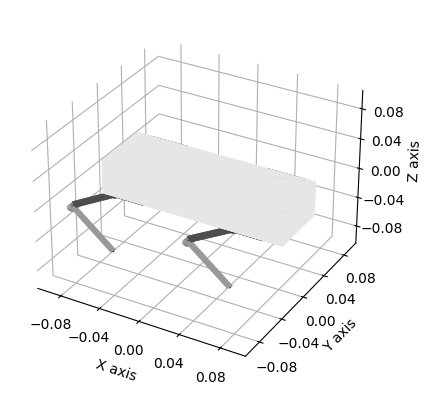

In [8]:
# arbitrary joint position for a nice robot rendering
joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  3.0, -3.0,  3.0, -3.0], # hips abduction revolute joints
        [145.0,145.0,145.0,145.0], # hips flexion/extension revolute joints
        [ 45.0, 45.0, 45.0, 45.0]  # knee flexion/extension revolute joints
    ]
))

tm.set_joint("FR-ABD", joint_position[0,0])
tm.set_joint("FL-ABD", joint_position[0,1])
tm.set_joint("RR-ABD", joint_position[0,2])
tm.set_joint("RL-ABD", joint_position[0,3])

tm.set_joint("FR-HIPS", joint_position[1,0])
tm.set_joint("FL-HIPS", joint_position[1,1])
tm.set_joint("RR-HIPS", joint_position[1,2])
tm.set_joint("RL-HIPS", joint_position[1,3])

tm.set_joint("FR-KNEE", joint_position[2,0]-joint_position[1,0])
tm.set_joint("FL-KNEE", joint_position[2,1]-joint_position[1,1])
tm.set_joint("RR-KNEE", joint_position[2,2]-joint_position[1,2])
tm.set_joint("RL-KNEE", joint_position[2,3]-joint_position[1,3])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax = tm.plot_connections_in("base_link", ax=ax)
tm.plot_visuals("base_link", ax_s=0.1, alpha=1.0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

## 6. Kinematics

In [9]:
import Kinematics

### 6.1. Leg Reference Frame(s) (LRF)

Each leg has its own reference frame:
* Right-hand coordinate system
* Centred on leg origin
* X upward
* Y leftward
* Z backward (**aligned** with the hips abduction revolute joint of the leg)

*Why such a reference frame? Because we will use the modified DH method to compute the FK. So, Z axis is the joint revolute axis.*

<img src="LRF.png" />

### 6.2. BRF to LRF transformation

Transformations from Body Reference Frame to a Leg Reference Frame require :
* a translation from body center to leg origins (using the previous leg origins matrix), 
* a rotation around Y axis by -90° (using a pitch rotation matrix, same for all legs). 


In [10]:
print("Leg origins in BRF (m):\n\n"+str(config.LEG_ORIGINS)+"\n")

Leg origins in BRF (m):

[[ 0.059   0.059  -0.059  -0.059 ]
 [-0.0235  0.0235 -0.0235  0.0235]
 [ 0.      0.      0.      0.    ]]



In [11]:
print("Pitch Rotation Matrix:\n\n"+str(Kinematics.R_BRF_to_LRF)+"\n")

Pitch Rotation Matrix:

[[ 0  0  1]
 [ 0  1  0]
 [-1  0  0]]



Here is the default standing pose relative to LRF, by using BRF to LRF transformation:

In [12]:
pose_relative_BRF = config.default_stance
print("Default standing pose in BRF (m):\n\n"+str(np.round(pose_relative_BRF,3))+"\n")

# transformation form BRF to LRF : one translation (LEG ORIGIN) + one rotation around Y (-90°)
pose_relative_LRF = np.zeros((3,4))
for i in range(4):
        pose_relative_LRF[:,i] = Kinematics.R_BRF_to_LRF.dot(pose_relative_BRF[:,i]-config.LEG_ORIGINS[:,i])
        
print("Default standing pose in LRF (m):\n\n"+str(np.round(pose_relative_LRF,3))+"\n")

Default standing pose in BRF (m):

[[ 0.059  0.059 -0.059 -0.059]
 [-0.05   0.05  -0.05   0.05 ]
 [-0.08  -0.08  -0.08  -0.08 ]]

Default standing pose in LRF (m):

[[-0.08  -0.08  -0.08  -0.08 ]
 [-0.027  0.027 -0.027  0.027]
 [ 0.     0.     0.     0.   ]]



### 6.3. Forward kinematics

The position of a foot in the LRF, is given by the joint positions of the corresponding leg:

$$ P = \text{FK}(\theta)
$$
where
$$
\theta = 
\begin{bmatrix} 
\theta_1 \\ 
\vdots \\ 
\theta_n 
\end{bmatrix}
$$


The forward kinematics formula is defined by using the modified Denavit-Hartenberg method.

The model of a revolute and and/or a prismatic joint is shown below:

<img src="modifiedDH.png" />

where
* **$\theta$** is rotation about Z axis of the current joint
* **d** is translation along Z axis of the current joint
* **a** is the length of the link attached to the current joint
* **$\alpha$** is the twist of the link about X axis attached to the current joint

The generic transformation matrix for a revolute and/or prismatic joint is:

$$
\text{T}^{i-1}_{i}(\theta_i,d_i,a_{i-1},\alpha_{i-1}) = 
\begin{bmatrix}
cos(\theta_i)                  & -sin(\theta_i)                 & 0                  & a_{i-1} \\
sin(\theta_i)cos(\alpha_{i-1}) & cos(\theta_i)cos(\alpha_{i-1}) & -sin(\alpha_{i-1}) & -d_i sin(\alpha_{i-1}) \\
sin(\theta_i)sin(\alpha_{i-1}) & cos(\theta_i)sin(\alpha_{i-1}) & cos(\alpha_{i-1})  &  d_i cos(\alpha_{i-1}) \\
0                              & 0                              & 0                  & 1
\end{bmatrix}
$$

The transformation matrix of a sequence of three joints is:

$$
\text{T}^{0}_{3}=\text{T}^{0}_{1}.\text{T}^{1}_{2}.\text{T}^{2}_{3}
$$

The position of the end-effector (foot) in the reference frame 0 (LRF) is the translation part of the final transformation matrix.

$$
\text{T} = 
\begin{bmatrix}
Rotation & \begin{matrix} FK_x \\ FK_y \\ FK_z \end{matrix} \\
\begin{matrix} 0 & 0 & 0 \end{matrix} & 1
\end{bmatrix}
$$


DH parameters for the front and rear left legs:
    
| Joint/Link | $\theta$ (rotation about Z)   | d (translation along Z) | a (length along X) | $\alpha$ (twist about X) |
|:---:       |:---:                          |:---:                    |:---:               |:---:                  |
| 1          |  $\theta_1$                   | 0                       | 0                  | -90°                  |
| 2          |  $\theta_2$+90°               | ABDUCTION_OFFSET        | LEG_LF             | 0°                    |
| 3          |  $\theta_3$-$\theta_2$        | 0                       | LEG_LT             | 0°                    |

DH parameters for the front and rear right legs:
    
| Joint/Link | $\theta$ (rotation about Z)   | d (translation along Z) | a (length along X) | $\alpha$ (twist about X) |
|:---:       |:---:                          |:---:                    |:---:               |:---:                  |
| 1          |  $\theta_1$                   | 0                       | 0                  | -90°                  |
| 2          |  $\theta_2$+90°               | -ABDUCTION_OFFSET       | LEG_LF             | 0°                    |
| 3          |  $\theta_3$-$\theta_2$        | 0                       | LEG_LT             | 0°                    |

where
* $\theta_1$ is the position of the HIPS adbuction revolute joint,
* $\theta_2$ is the position of the HIPS flexion/extension revolute joint,
* $\theta_3$ is the position of the KNEE flexion/extension revolute joint.

Joint position is positive, according the CCW/TRIGO direction.

When all revolute joints are zero, the leg pose is:
* $\theta_1=0$ ==> the leg is VERTICAL, pointing down.
* $\theta_2=0$ ==> the femur is HORIZONTAL, pointing forward.
* $\theta_3=0$ ==> the tibia is HORIZONTAL, pointing forward.

<img src="Angles.png" />

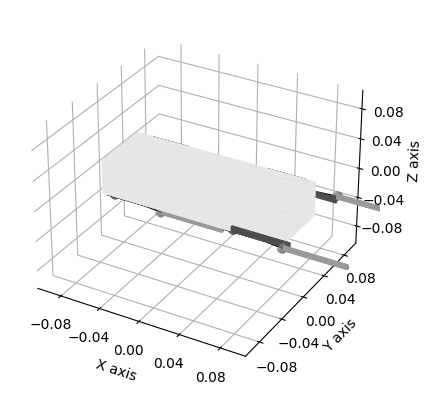

In [13]:
joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0, 0.0, 0.0], # hips abduction revolute joints
        [  0.0,  0.0, 0.0, 0.0], # hips flexion/extension revolute joints
        [  0.0,  0.0, 0.0, 0.0]  # knee flexion/extension revolute joints
    ]
))

tm.set_joint("FR-ABD", joint_position[0,0])
tm.set_joint("FL-ABD", joint_position[0,1])
tm.set_joint("RR-ABD", joint_position[0,2])
tm.set_joint("RL-ABD", joint_position[0,3])

tm.set_joint("FR-HIPS", joint_position[1,0])
tm.set_joint("FL-HIPS", joint_position[1,1])
tm.set_joint("RR-HIPS", joint_position[1,2])
tm.set_joint("RL-HIPS", joint_position[1,3])

tm.set_joint("FR-KNEE", joint_position[2,0]-joint_position[1,0])
tm.set_joint("FL-KNEE", joint_position[2,1]-joint_position[1,1])
tm.set_joint("RR-KNEE", joint_position[2,2]-joint_position[1,2])
tm.set_joint("RL-KNEE", joint_position[2,3]-joint_position[1,3])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax = tm.plot_connections_in("base_link", ax=ax)
tm.plot_visuals("base_link", ax_s=0.10, alpha=1.0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

Note : The zero KNEE joint position leads to maximum flexion, so that the tibia and femur are aligned and pointing forward.

The pose with all zero joint position is not physically reachable, as the femur will collide the tibia.


The DH method gives the forward kinematics functions :
* parameters : the joint positions of the leg,
* result : the 3D coordinates of the foot in the leg reference frame.

For the left legs:
$$
\text{FK}(\theta_1,\theta_2,\theta_3) = 
\begin{bmatrix}
c_{1}.c_{3}.\text{LEG_LT}+c_{1}.c_{2}.\text{LEG_LF}-s_{1}.\text{ABDUCTION_OFFSET} \\
s_{1}.c_{3}.\text{LEG_LT}+s_{1}.c_{2}.\text{LEG_LF}+c_{1}.\text{ABDUCTION_OFFSET} \\
-s_{3}.\text{LEG_LT}-s_{2}.\text{LEG_LF}
\end{bmatrix}
$$

For the left legs:
$$
\text{FK}(\theta_1,\theta_2,\theta_3) = 
\begin{bmatrix}
c_{1}.c_{3}.\text{LEG_LT}+c_{1}.c_{2}.\text{LEG_LF}+s_{1}.\text{ABDUCTION_OFFSET} \\
s_{1}.c_{3}.\text{LEG_LT}+s_{1}.c_{2}.\text{LEG_LF}-c_{1}.\text{ABDUCTION_OFFSET} \\
-s_{3}.\text{LEG_LT}-s_{2}.\text{LEG_LF}
\end{bmatrix}
$$

where
* $c_{1} = cos(\theta_1)$
* $s_{1} = sin(\theta_1)$
* $c_{2} = -sin(\theta_2)$
* $s_{2} = cos(\theta_2)$
* $c_{3} = -sin(\theta_3)$
* $s_{3} = cos(\theta_3)$

Let's define an arbitrary set of joint positions, and check the foot positions, by using the forward kinematics formula:

In [14]:
joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0, 23.0,-15.0], # hips abduction revolute joints
        [180.0, 90.0,125.0,180.0], # hips flexion/extension revolute joints
        [ 90.0, 90.0, 45.0,170.0]  # knee flexion/extension revolute joints
    ]
))
print("joint_position:\n\n"+str(np.round(np.degrees(joint_position),1))+"\n")

feet_LRF = Kinematics.four_legs_forward_kinematics_LRF(joint_position,config)
print("feet_LRF:\n\n"+str(np.round(feet_LRF,3))+"\n")

# transformation form LRF to BRF : one translation (LEG ORIGIN) + one rotation around Y (-90°)
feet_BRF = np.zeros((3,4))
for i in range(4):
        feet_BRF[:,i] = Kinematics.R_BRF_to_LRF.transpose().dot(feet_LRF[:,i])+config.LEG_ORIGINS[:,i]
print("feet_BRF:\n\n"+str(np.round(feet_BRF,3))+"\n")

joint_position:

[[  0.   0.  23. -15.]
 [180.  90. 125. 180.]
 [ 90.  90.  45. 170.]]

feet_LRF:

[[-0.06  -0.11  -0.067 -0.003]
 [-0.026  0.026 -0.057  0.028]
 [ 0.05  -0.    -0.014  0.109]]

feet_BRF:

[[ 0.009  0.059 -0.045 -0.168]
 [-0.05   0.05  -0.08   0.051]
 [-0.06  -0.11  -0.067 -0.003]]



Let's compare the feet positions in BRF given by the forward kenamatics with the URDF transform3D tool:

In [15]:
joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0, 23.0,-15.0], # hips abduction revolute joints
        [180.0, 90.0,125.0,180.0], # hips flexion/extension revolute joints
        [ 90.0, 90.0, 45.0,170.0]  # knee flexion/extension revolute joints
    ]
))

tm.set_joint("FR-ABD", joint_position[0,0])
tm.set_joint("FL-ABD", joint_position[0,1])
tm.set_joint("RR-ABD", joint_position[0,2])
tm.set_joint("RL-ABD", joint_position[0,3])

tm.set_joint("FR-HIPS", joint_position[1,0])
tm.set_joint("FL-HIPS", joint_position[1,1])
tm.set_joint("RR-HIPS", joint_position[1,2])
tm.set_joint("RL-HIPS", joint_position[1,3])

tm.set_joint("FR-KNEE", joint_position[2,0]-joint_position[1,0])
tm.set_joint("FL-KNEE", joint_position[2,1]-joint_position[1,1])
tm.set_joint("RR-KNEE", joint_position[2,2]-joint_position[1,2])
tm.set_joint("RL-KNEE", joint_position[2,3]-joint_position[1,3])

# extract transformations
legs = ["FR","FL","RR","RL"]
feet_BRF = np.zeros((3,4))
for leg_index in range(4):
	feet_BRF[:,leg_index] = tm.get_transform('%s-foot' % legs[leg_index], 'base_link')[0:3,3]
print("feet_BRF:\n\n"+str(np.round(feet_BRF,3))+"\n")

feet_BRF:

[[ 0.009  0.059 -0.045 -0.168]
 [-0.049  0.05  -0.08   0.051]
 [-0.06  -0.11  -0.067 -0.003]]



This is the expected result. Forward kinematics should be alright!

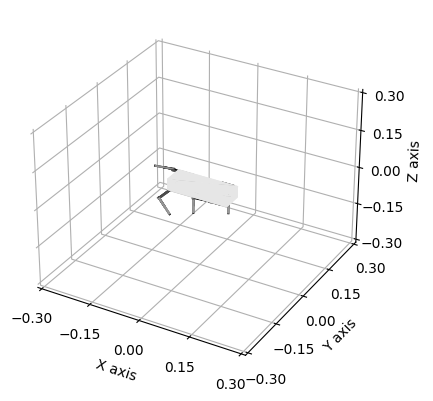

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax = tm.plot_connections_in("base_link", ax=ax)
tm.plot_visuals("base_link", ax_s=0.30, alpha=1.0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

### 6.4. Jacobian

The velocity of a foot in the LRF, is given by the Jacobian J and the joint position and the joint speed:

$$ \dot P = J(\theta)  .  \dot \theta
$$
where
$$
\theta = 
\begin{bmatrix} 
\theta_1 \\ 
\theta_2 \\ 
\theta_3 
\end{bmatrix}
$$
$$
\dot \theta = 
\begin{bmatrix} 
\dot \theta_1 \\ 
\dot \theta_2 \\ 
\dot \theta_3 
\end{bmatrix}
$$

Jacobian J is the partial derivative of the forward kinematics:

$$ J(\theta) =
\begin{bmatrix} 
\frac{dFK_x}{d\theta_1} & \frac{dFK_x}{d\theta_2} & \frac{dFK_x}{d\theta_3} \\
\frac{dFK_y}{d\theta_1} & \frac{dFK_y}{d\theta_2} & \frac{dFK_y}{d\theta_3} \\
\frac{dFK_z}{d\theta_1} & \frac{dFK_z}{d\theta_2} & \frac{dFK_z}{d\theta_3} \\
\end{bmatrix}
$$

For the left legs:

$$
\text{J}(\theta_1,\theta_2,\theta_3) = 
\begin{bmatrix}
-s_{1}.c_{3}.\text{LEG_LT}-s_{1}.c_{2}.\text{LEG_LF}-c_{1}.\text{ABDUCTION_OFFSET} &
-c_{1}.s_{3}.\text{LEG_LT}-c_{1}.s_{2}.\text{LEG_LF} &
-c_{1}.s_{3}.\text{LEG_LT} \\
c_{1}.c_{3}.\text{LEG_LT}+c_{1}.c_{2}.\text{LEG_LF}-s_{1}.\text{ABDUCTION_OFFSET} &
-s_{1}.s_{3}.\text{LEG_LT}-s_{1}.s_{2}.\text{LEG_LF} &
-s_{1}.s_{3}.\text{LEG_LT} \\
0 &
-c_{3}.\text{LEG_LT}-c_{2}.\text{LEG_LF} &
-c_{3}.\text{LEG_LT} 
\end{bmatrix}
$$

For the right legs:

$$
\text{J}(\theta_1,\theta_2,\theta_3) = 
\begin{bmatrix}
-s_{1}.c_{3}.\text{LEG_LT}-s_{1}.c_{2}.\text{LEG_LF}+c_{1}.\text{ABDUCTION_OFFSET} &
-c_{1}.s_{3}.\text{LEG_LT}-c_{1}.s_{2}.\text{LEG_LF} &
-c_{1}.s_{3}.\text{LEG_LT} \\
c_{1}.c_{3}.\text{LEG_LT}+c_{1}.c_{2}.\text{LEG_LF}+s_{1}.\text{ABDUCTION_OFFSET} &
-s_{1}.s_{3}.\text{LEG_LT}-s_{1}.s_{2}.\text{LEG_LF} &
-s_{1}.s_{3}.\text{LEG_LT} \\
0 &
-c_{3}.\text{LEG_LT}-c_{2}.\text{LEG_LF} &
-c_{3}.\text{LEG_LT} 
\end{bmatrix}
$$

where
* $c_{1} = cos(\theta_1)$
* $s_{1} = sin(\theta_1)$
* $c_{2} = -sin(\theta_2)$
* $s_{2} = cos(\theta_2)$
* $c_{3} = -sin(\theta_3)$
* $s_{3} = cos(\theta_3)$

Let's check the Jacobians! 

The robot is in an arbitrary standing pose, and it starts an in-place hop.

HIPS flexion and KNEE extension will probably cause the feet to move downward...

In [17]:
# arbitrary joint positions
joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0,  0.0,  0.0], # hips abduction revolute joints
        [139.0,139.0,139.0,139.0], # hips flexion/extension revolute joints
        [ 86.0, 86.0, 86.0, 86.0]  # knee flexion/extension revolute joints
    ]
))

# compute feet positions in LRF
feet_position_LRF = Kinematics.four_legs_forward_kinematics_LRF(joint_position,config)

# transformation feet positions form LRF to BRF : one translation (LEG ORIGIN) + one rotation around Y (-90°)
feet_position_BRF = np.zeros((3,4))
for i in range(4):
        feet_position_BRF[:,i] = Kinematics.R_BRF_to_LRF.transpose().dot(feet_position_LRF[:,i])+config.LEG_ORIGINS[:,i]
print("feet_position_BRF:\n\n"+str(np.round(feet_position_BRF,3))+"\n")

# HIPS flexion and KNEE extension with an arbitrary speed (radians per seconds)
joint_speed = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0,  0.0, 0.0], # hips abduction revolute joints
        [-1.0, -1.0, -1.0, -1.0], # hips flexion/extension revolute joints
        [ 2.0,  2.0,  2.0,  2.0]  # knee flexion/extension revolute joints
    ]
))

# compute Jacobian and then feet velocities in LRF based on joint positions and joint speeds
feet_velocity_LRF = np.zeros((3,4))
for leg_index in range(4):
    J = Kinematics.jacobian(joint_position[:,leg_index],leg_index,config)
    feet_velocity_LRF[:,leg_index] = J @ joint_speed[:,leg_index]

# transformation of the feet velocities from LRF to BRF : one rotation around Y (-90°)
feet_velocity_BRF = np.zeros((3,4))
for i in range(4):
        feet_velocity_BRF[:,i] = Kinematics.R_BRF_to_LRF.transpose().dot(feet_velocity_LRF[:,i])
print("feet_velocity_BRF:\n\n"+str(np.round(feet_velocity_BRF,3))+"\n")

feet_position_BRF:

[[ 0.025  0.025 -0.093 -0.093]
 [-0.05   0.05  -0.05   0.05 ]
 [-0.093 -0.093 -0.093 -0.093]]

feet_velocity_BRF:

[[-0.    -0.    -0.    -0.   ]
 [ 0.     0.     0.     0.   ]
 [-0.001 -0.001 -0.001 -0.001]]



The velocity of the four feet is vertical and oriented downward (-Z). This is the expected result ! Jacobian should be alright!

### 6.5. Inverse Kinematics

The position of the joints is given by the foot position  in the LRF of the corresponding leg:

$$ \theta = \text{IK}(x,y,z)
$$
where
$$
\theta = 
\begin{bmatrix} 
\theta_1 \\ 
\vdots \\ 
\theta_n 
\end{bmatrix}
$$


The Jacobian method has is an iterative algorithm with five steps:
* Compute the current foot position $P = \text{FK}(\theta)$ using the current joint positions $\theta$
* Compute the error $\Delta P$ between goal position and current position
* Compute the Jacobian $J(\theta)$ using the current joint positions $\theta$
* Compute the joint correction  $\Delta \theta = J(\theta)^{-1}.\Delta P$
* Update the joint position with a factor $\theta = \theta + \alpha.\Delta \theta$

When goal position is near the present position, a small number (~5) of iterations gives a very good accuracy (<0.0001m).

In [18]:
# arbitrary present joint positions
present_joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0,  0.0,  0.0], # hips abduction revolute joints
        [139.0,139.0,139.0,139.0], # hips flexion/extension revolute joints
        [ 86.0, 86.0, 86.0, 86.0]  # knee flexion/extension revolute joints
    ]
))

# compute present feet positions in BRF
present_feet_position_BRF = Kinematics.four_legs_forward_kinematics_BRF(present_joint_position,config)
print("Present feet position BRF:\n\n"+str(np.round(present_feet_position_BRF,3))+"\n")

# here is the expected result.
expected_joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0, 25.0,-15.0], # hips abduction revolute joints
        [180.0, 90.0,125.0,180.0], # hips flexion/extension revolute joints
        [ 90.0, 90.0, 45.0,170.0]  # knee flexion/extension revolute joints
    ]
))

# apply FK to find the target feet positions in BRF
target_feet_position_BRF = Kinematics.four_legs_forward_kinematics_BRF(expected_joint_position,config)
print("Target feet positions BRF:\n\n"+str(np.round(target_feet_position_BRF,3))+"\n")

# now try IK...

# transformation from BRF to LRF : one translation (LEG ORIGIN) + one rotation around Y (-90°)
target_feet_position_LRF = np.zeros((3,4))
for i in range(4):
        target_feet_position_LRF[:,i] = Kinematics.R_BRF_to_LRF.dot(target_feet_position_BRF[:,i]-config.LEG_ORIGINS[:,i])
        
IK_joint_positions = Kinematics.four_legs_inverse_kinematics_LRF(target_feet_position_LRF,present_joint_position,config)
print("IK computed joint positions:\n\n"+str(np.round(np.degrees(IK_joint_positions),1))+"\n")

print("Expected joint positions:\n\n"+str(np.round(np.degrees(expected_joint_position),1))+"\n")

Present feet position BRF:

[[ 0.025  0.025 -0.093 -0.093]
 [-0.05   0.05  -0.05   0.05 ]
 [-0.093 -0.093 -0.093 -0.093]]

Target feet positions BRF:

[[ 0.009  0.059 -0.045 -0.168]
 [-0.05   0.05  -0.082  0.051]
 [-0.06  -0.11  -0.065 -0.003]]

IK computed joint positions:

[[  0.   -0.   25.  -15. ]
 [180.   90.2 125.  180. ]
 [ 90.   90.1  45.  170. ]]

Expected joint positions:

[[  0.   0.  25. -15.]
 [180.  90. 125. 180.]
 [ 90.  90.  45. 170.]]



In [19]:
# arbitrary present joint positions
present_joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0,  0.0,  0.0], # hips abduction revolute joints
        [139.0,139.0,139.0,139.0], # hips flexion/extension revolute joints
        [ 86.0, 86.0, 86.0, 86.0]  # knee flexion/extension revolute joints
    ]
))

# compute present feet positions in BRF
present_feet_position_BRF = Kinematics.four_legs_forward_kinematics_BRF(present_joint_position,config)
print("Present feet position BRF:\n\n"+str(np.round(present_feet_position_BRF,3))+"\n")

# here is the expected result.
expected_joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0, 2.0,  -2.0], # hips abduction revolute joints
        [141.0,139.0,139.0,137.0], # hips flexion/extension revolute joints
        [ 86.0, 84.0, 86.0, 89.0]  # knee flexion/extension revolute joints
    ]
))

# apply FK to find the target feet positions in BRF
target_feet_position_BRF = Kinematics.four_legs_forward_kinematics_BRF(expected_joint_position,config)
print("Target feet positions BRF:\n\n"+str(np.round(target_feet_position_BRF,3))+"\n")

# now try IK...

# transformation from BRF to LRF : one translation (LEG ORIGIN) + one rotation around Y (-90°)
target_feet_position_LRF = np.zeros((3,4))
for i in range(4):
        target_feet_position_LRF[:,i] = Kinematics.R_BRF_to_LRF.dot(target_feet_position_BRF[:,i]-config.LEG_ORIGINS[:,i])
        
IK_joint_positions = Kinematics.four_legs_inverse_kinematics_LRF(target_feet_position_LRF,present_joint_position,config)
print("IK computed joint positions:\n\n"+str(np.round(np.degrees(IK_joint_positions),1))+"\n")

print("Expected joint positions:\n\n"+str(np.round(np.degrees(expected_joint_position),1))+"\n")

Present feet position BRF:

[[ 0.025  0.025 -0.093 -0.093]
 [-0.05   0.05  -0.05   0.05 ]
 [-0.093 -0.093 -0.093 -0.093]]

Target feet positions BRF:

[[ 0.024  0.028 -0.093 -0.095]
 [-0.05   0.05  -0.053  0.053]
 [-0.091 -0.092 -0.092 -0.093]]

IK computed joint positions:

[[  0.   -0.    2.   -2. ]
 [141.  139.  139.  137. ]
 [ 86.1  84.1  86.   89. ]]

Expected joint positions:

[[  0.   0.   2.  -2.]
 [141. 139. 139. 137.]
 [ 86.  84.  86.  89.]]



This is the expected result. Iterative inverse kinematics should be alright!

### 6.6. Inverse Kinematics (back-up)

Another method to compute the inverse kinematics is analyticaly by using trigonommetry.

*Solution not detailled*

In [20]:
# here is the expected result.
expected_joint_position = np.radians(np.array(
    [   #   FR,   FL,   RR,   RL
        [  0.0,  0.0, 25.0,-15.0], # hips abduction revolute joints
        [180.0, 90.0,125.0,180.0], # hips flexion/extension revolute joints
        [ 90.0, 90.0, 45.0,170.0]  # knee flexion/extension revolute joints
    ]
))

# apply FK to find the target feet positions in BRF
target_feet_position_BRF = Kinematics.four_legs_forward_kinematics_BRF(expected_joint_position,config)
print("Target feet positions BRF:\n\n"+str(np.round(target_feet_position_BRF,3))+"\n")

# now try IK...

# transformation form BRF to LRF : one translation (LEG ORIGIN) + one rotation around Y (-90°)
target_feet_position_LRF = np.zeros((3,4))
for i in range(4):
        target_feet_position_LRF[:,i] = Kinematics.R_BRF_to_LRF.dot(target_feet_position_BRF[:,i]-config.LEG_ORIGINS[:,i])
        
IK_joint_positions = Kinematics.four_legs_explicit_inverse_kinematics_LRF(target_feet_position_LRF,config)
print("IK computed joint positions:\n\n"+str(np.round(np.degrees(IK_joint_positions),1))+"\n")
print("Expected joint positions:\n\n"+str(np.round(np.degrees(expected_joint_position),1))+"\n")

Target feet positions BRF:

[[ 0.009  0.059 -0.045 -0.168]
 [-0.05   0.05  -0.082  0.051]
 [-0.06  -0.11  -0.065 -0.003]]

IK computed joint positions:

[[  0.  -0.  25. -15.]
 [180.  90. 125. 180.]
 [ 90.  90.  45. 170.]]

Expected joint positions:

[[  0.   0.  25. -15.]
 [180.  90. 125. 180.]
 [ 90.  90.  45. 170.]]



This is the expected result. Analytical inverse kinematics should be alright!

## 7. Leg space & joint limits

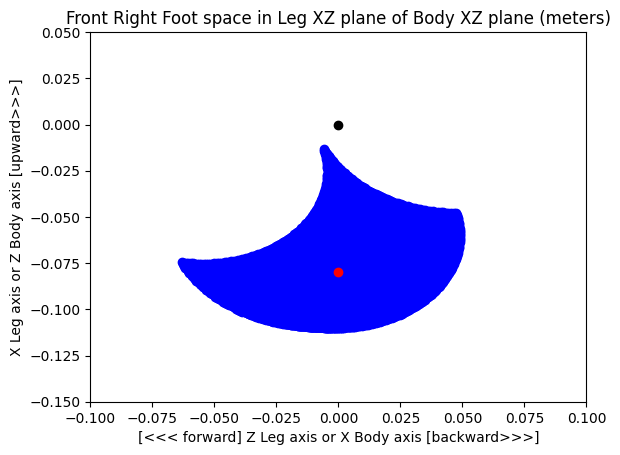

In [21]:
X =[]
Y =[]
Z =[]
for h in range(80,195,1):
     for k in range(25,90,1):
                joint_position = np.radians(np.array([0, h, k]))
                (x,y,z) = Kinematics.leg_forward_kinematics_LRF(joint_position,0,config)
                X.append(x)
                Y.append(y)
                Z.append(z)


# plot
fig, ax = plt.subplots()
ax.scatter(Z,X,c="blue")
ax.scatter(0,0,c="black") # leg origin
ax.scatter(config.STANCE_X+config.STANCE_X_SHIFT-config.LEG_OX,config.STANCE_Z,c="red") # Foot position in default standing pose
ax.set(xlim=(-0.1, 0.1), ylim=(-0.15, 0.05))
ax.set_title('Front Right Foot space in Leg XZ plane of Body XZ plane (meters)')
ax.set_xlabel('[<<< forward] Z Leg axis or X Body axis [backward>>>]')
ax.set_ylabel('X Leg axis or Z Body axis [upward>>>]')
plt.show()

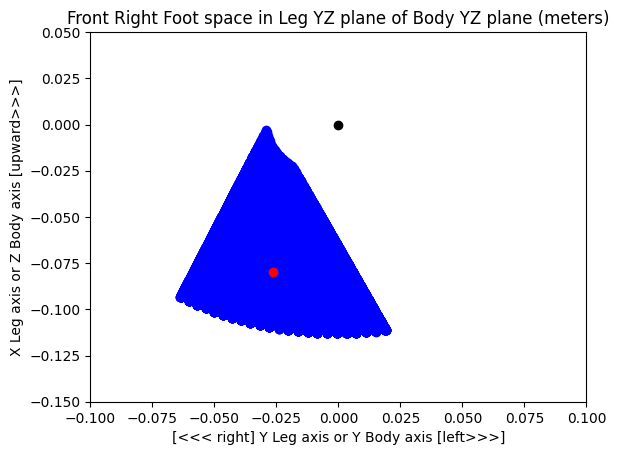

In [22]:
X =[]
Y =[]
Z =[]
for h in range(80,195,2):
     for k in range(25,90,2):
            for a in range(-23,+23,2):
                joint_position = np.radians(np.array([a, h, k]))
                (x,y,z) = Kinematics.leg_forward_kinematics_LRF(joint_position,0,config)
                X.append(x)
                Y.append(y)
                Z.append(z)

# plot
fig, ax = plt.subplots()
ax.scatter(Y,X,c="blue")
ax.scatter(0,0,c="black") # leg origin
ax.scatter(-config.STANCE_Y+config.LEG_OY,config.STANCE_Z,c="red") # Foot position in default standing pose
ax.set(xlim=(-0.1, 0.1),ylim=(-0.15, 0.05))
ax.set_title('Front Right Foot space in Leg YZ plane of Body YZ plane (meters)')
ax.set_xlabel('[<<< right] Y Leg axis or Y Body axis [left>>>]')
ax.set_ylabel('X Leg axis or Z Body axis [upward>>>]')
plt.show()